# Modelling Surface Energy Balance at an AmeriFlux Site

This tutorial demonstrates the workflow of modelling surface energy balance (SEB) at a chosen AmeriFlux (AMF) site using SuPy/SUEWS, consisting of


1. [prepare input data](#Prepare-input-data)
2. [run simulation](#Run-simulations)
3. [examine results](#Examine-results)
4. [more explorations](#More-explorations-into-simulation-results)

More advanced use of `supy` are available in the [tutorials](./tutorial.rst#tutorials)

Before start, we need to load the following necessary packages.

In [33]:
import matplotlib.pyplot as plt
import supy as sp
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

# produce high-quality figures, which can also be set as one of ['svg', 'pdf', 'retina', 'png']
# 'svg' produces high quality vector figures
# %config InlineBackend.figure_format = 'svg'

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
sp.show_version()

supy: 2019.11.18dev
supy_driver: 2019a18


## Prepare input data

### Overview of SuPy input 

#### Load sample data:


To ease the input file preparation, a helper function `load_SampleData` is provided to get the sample input for SuPy simulations 

In [36]:
df_state_init, df_forcing = sp.load_SampleData()

2019-11-18 23:30:23,116 — SuPy — INFO — All cache cleared.


#### `df_state_init`

`df_state_init` includes model Initial state consisting of:

* surface characteristics (e.g., albedo, emissivity, land cover fractions, etc.; full details refer to [SUEWS documentation](https://suews-docs.readthedocs.io/en/latest/input_files/SUEWS_SiteInfo/SUEWS_SiteInfo.html))

* model configurations (e.g., stability; full details refer to [SUEWS documentation](https://suews-docs.readthedocs.io/en/latest/input_files/RunControl/RunControl.html))

Detailed description of variables in `df_state_init` refers to [SuPy input](../data-structure/supy-io.ipynb#df_state_init:-model-initial-states)

Surface land cover fraction information in the sample input dataset:

In [37]:
df_state_init.loc[:, ['bldgh', 'evetreeh', 'dectreeh']]

var,bldgh,dectreeh,evetreeh
ind_dim,0,0,0
grid,,,
98,22.0,13.1,13.1


In [38]:
df_state_init.filter(like='sfr')

var       sfr                                        
ind_dim  (0,)  (1,)   (2,)   (3,)   (4,)   (5,)  (6,)
grid                                                 
98       0.43  0.38  0.001  0.019  0.029  0.001  0.14

#### `df_forcing`

`df_forcing` includes meteorological and other external forcing information.

Detailed description of variables in `df_forcing` refers to [SuPy input](../data-structure/supy-io.ipynb#df_forcing:-forcing-data).

Below is a view of heading lines of the forcing variables.

In [40]:
df_forcing.head()

,iy,id,it,imin,qn,qh,qe,qs,qf,U,...,snow,ldown,fcld,Wuh,xsmd,lai,kdiff,kdir,wdir,isec
2012-01-01 00:05:00,2012,1,0,5,-999.0,-999.0,-999.0,-999.0,-999.0,4.5225,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
2012-01-01 00:10:00,2012,1,0,10,-999.0,-999.0,-999.0,-999.0,-999.0,4.5225,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
2012-01-01 00:15:00,2012,1,0,15,-999.0,-999.0,-999.0,-999.0,-999.0,4.5225,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
2012-01-01 00:20:00,2012,1,0,20,-999.0,-999.0,-999.0,-999.0,-999.0,4.5225,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0
2012-01-01 00:25:00,2012,1,0,25,-999.0,-999.0,-999.0,-999.0,-999.0,4.5225,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0


### Site-specific configuration of surface parameters

Given `pandas.DataFrame` as the core data structure of SuPy, all operations, including modification, output, demonstration, etc., on SuPy inputs (`df_state_init` and `df_forcing`) can be done using `pandas`-based functions/methods.
Please see [SuPy quickstart](https://supy.readthedocs.io/en/latest/tutorial/quick-start.html#Modification-of-SuPy-input) for methods to do so.

Below we will modify several key properties of the chosen site with appropriate values to run SuPy.
First, we copy the `df_state_init` to have a new DataFrame for manipulation.

In [41]:
df_state_amf = df_state_init.copy()

In [42]:
name_site = 'US-AR1'

#### location

In [43]:
df_state_amf.loc[:, 'lat'] = 41.37
df_state_amf.loc[:, 'lng'] = -106.24
df_state_amf.loc[:, 'alt'] = 611.

#### land cover fraction

In [44]:
# view the surface fraction variable: `sfr`
df_state_amf.loc[:, 'sfr'] = 0
df_state_amf.loc[:, ('sfr', '(4,)')] = 1
df_state_amf.loc[:, 'sfr']

ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
98,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### albedo

In [45]:
df_state_amf.albmax_grass = 0.19
df_state_amf.albmin_grass = 0.14

In [46]:
df_state_amf.loc[:, ('alb', '(4,)')] = 0.14

#### LAI/phenology

In [47]:
# LAI
df_state_amf.loc[:, ('laimax', '(2,)')] = 1
df_state_amf.loc[:, ('laimin', '(2,)')] = 0.2

In [48]:
# BaseT
df_state_amf.loc[:, ('baset', '(2,)')] = 5
# BaseTe
df_state_amf.loc[:, ('basete', '(2,)')] = 20

In [49]:
# SDDFull
df_state_amf.loc[:, ('sddfull', '(2,)')] = -1000
# GDDFull
df_state_amf.loc[:, ('gddfull', '(2,)')] = 1000

#### surface resistance

In [50]:
df_state_amf.maxconductance = 18.7
df_state_amf.g1 = 1
df_state_amf.g2 = 104.215
df_state_amf.g3 = 0.424
df_state_amf.g4 = 0.814
df_state_amf.g5 = 36.945
df_state_amf.g6 = 0.025

#### measurement height

In [51]:
df_state_amf.z = 2.84

#### urban feature

In [52]:
# disable anthropogenic heat by setting zero population
df_state_amf.popdensdaytime = 0
df_state_amf.popdensnighttime = 0

#### validate `df_state`

In [53]:
sp.check_state(df_state_amf)

2019-11-18 23:32:05,667 — SuPy — INFO — SuPy is validating `df_state`...
2019-11-18 23:32:05,827 — SuPy — INFO — All checks for `df_state` passed!


### prepare forcing conditions

Here we use the a SuPy utility function `read_forcing` to read in forcing data from an external file in the format of SUEWS input.
Also note, this `read_forcing` utility will also resample the forcing data to a proper temporal resolution to run SuPy/SUEWS, which is usually 5 min (300 sec).

#### load and resample forcing data

In [54]:
df_forcing_amf = sp.util.read_forcing('./data/US-AR1_2010_data_60.txt',
                                      tstep_mod=300)
_ = sp.check_forcing(df_forcing_amf)

2019-11-18 23:32:09,859 — SuPy — INFO — SuPy is validating `df_forcing`...
2019-11-18 23:32:12,354 — SuPy — ERROR — Issues found in `df_forcing`:
`kdown` should be between [0, 1400] but `-1.2544270833333333` is found at 2009-12-31 23:05:00


In [55]:
# modify invalid values
df_forcing_amf.kdown = df_forcing_amf.kdown.where(df_forcing_amf.kdown > 0, 0)

In [56]:
# validate `df_forcing` again
_ = sp.check_forcing(df_forcing_amf)

2019-11-18 23:32:21,956 — SuPy — INFO — SuPy is validating `df_forcing`...
2019-11-18 23:32:24,516 — SuPy — INFO — All checks for `df_forcing` passed!


#### examine forcing data

We can examine the forcing data as we did for the sample data:

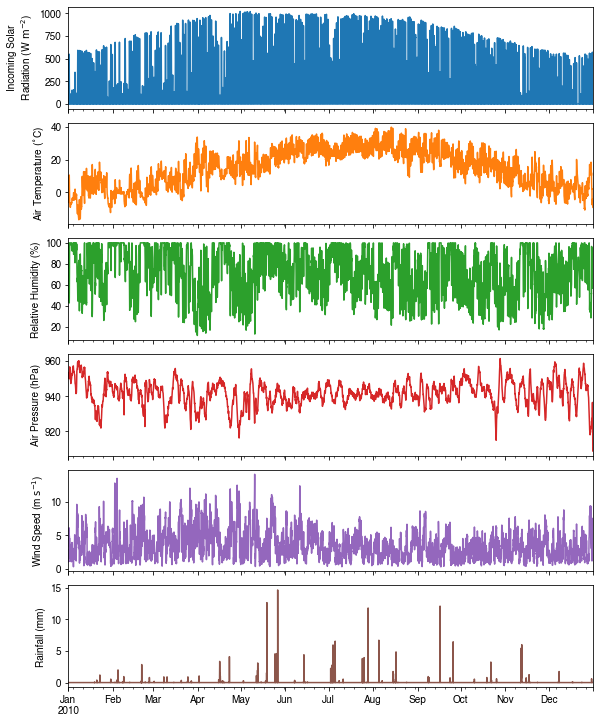

In [57]:
list_var_forcing = [
    'kdown',
    'Tair',
    'RH',
    'pres',
    'U',
    'rain',
]
dict_var_label = {
    'kdown': 'Incoming Solar\n Radiation ($ \mathrm{W \ m^{-2}}$)',
    'Tair': 'Air Temperature ($^{\circ}}$C)',
    'RH': r'Relative Humidity (%)',
    'pres': 'Air Pressure (hPa)',
    'rain': 'Rainfall (mm)',
    'U': 'Wind Speed (m $\mathrm{s^{-1}}$)'
}
df_plot_forcing_x = df_forcing_amf.loc[:, list_var_forcing].copy().shift(
    -1).dropna(how='any')
df_plot_forcing = df_plot_forcing_x.resample('1h').mean()
df_plot_forcing['rain'] = df_plot_forcing_x['rain'].resample('1h').sum()

axes = df_plot_forcing.plot(
    subplots=True,
    figsize=(8, 12),
    legend=False,
)
fig = axes[0].figure
fig.tight_layout()
fig.autofmt_xdate(bottom=0.2, rotation=0, ha='center')
for ax, var in zip(axes, list_var_forcing):
    _ = ax.set_ylabel(dict_var_label[var])

## Run simulations

Once met-forcing (via `df_forcing`) and initial conditions (via `df_state_init`) are loaded in, we call `sp.run_supy` to conduct a SUEWS simulation, which will return two `pandas` `DataFrame`s: `df_output` and `df_state`.

In [58]:
df_output, df_state_final = sp.run_supy(df_forcing_amf, df_state_amf)

2019-11-18 23:33:04,015 — SuPy — INFO — ====================
2019-11-18 23:33:04,016 — SuPy — INFO — Simulation period:
2019-11-18 23:33:04,016 — SuPy — INFO —   Start: 2009-12-31 23:05:00
2019-11-18 23:33:04,018 — SuPy — INFO —   End: 2010-12-31 23:00:00
2019-11-18 23:33:04,019 — SuPy — INFO — 
2019-11-18 23:33:04,020 — SuPy — INFO — No. of grids: 1
2019-11-18 23:33:04,020 — SuPy — INFO — SuPy is running in serial mode
2019-11-18 23:33:16,756 — SuPy — INFO — Execution time: 12.7 s
2019-11-18 23:33:16,757 — SuPy — INFO — ====================



### `df_output`

`df_output` is an ensemble output collection of major SUEWS output groups, including:

* SUEWS: the essential SUEWS output variables
* DailyState: variables of daily state information
* snow: snow output variables (effective when `snowuse = 1` set in `df_state_init`)

Detailed description of variables in `df_output` refers to [SuPy output](../data-structure/supy-io.html#df_output:-model-output-results)

In [59]:
df_output.columns.levels[0]

Index(['SUEWS', 'snow', 'RSL', 'DailyState'], dtype='object', name='group')

### `df_state_final`

`df_state_final` is a `DataFrame` for holding:

1. all model states if `save_state` is set to `True` when calling `sp.run_supy` and `supy` may run significantly slower for a large simulation;
2. or, only the final state if `save_state` is set to `False` (the default setting) in which mode `supy` has a similar performance as the standalone compiled SUEWS executable.

Entries in `df_state_final` have the same data structure as `df_state_init` and can thus be used for other SUEWS simulations staring at the timestamp as in `df_state_final`.

Detailed description of variables in `df_state_final` refers to [SuPy output](../data-structure/supy-io.html#df_state_final:-model-final-states)

In [60]:
df_state_final.T.head()

datetime                 2009-12-31 23:05:00 2010-12-31 23:05:00
grid                                      98                  98
var              ind_dim                                        
ah_min           (0,)                   15.0                15.0
                 (1,)                   15.0                15.0
ah_slope_cooling (0,)                    2.7                 2.7
                 (1,)                    2.7                 2.7
ah_slope_heating (0,)                    2.7                 2.7

## Examine results

Thanks to the functionality inherited from `pandas` and other packages under the [PyData](https://pydata.org) stack, compared with the standard SUEWS simulation workflow, `supy` enables more convenient examination of SUEWS results by statistics calculation, resampling, plotting (and many more).

### Ouptut structure

`df_output` is organised with `MultiIndex` `(grid,timestamp)` and `(group,varaible)` as `index` and `columns`, respectively.

In [61]:
df_output.head()

group                    SUEWS                                         \
var                      Kdown  Kup       Ldown         Lup     Tsurf   
grid datetime                                                           
98   2009-12-31 23:05:00   0.0  0.0  258.769753  297.995932 -3.244854   
     2009-12-31 23:10:00   0.0  0.0  258.769753  297.995932 -3.244854   
     2009-12-31 23:15:00   0.0  0.0  258.769753  297.995932 -3.244854   
     2009-12-31 23:20:00   0.0  0.0  258.769753  297.995932 -3.244854   
     2009-12-31 23:25:00   0.0  0.0  258.769753  297.995932 -3.244854   

group                                                                     ...  \
var                              QN   QF         QS         QH        QE  ...   
grid datetime                                                             ...   
98   2009-12-31 23:05:00 -39.226179  0.0 -50.718893  11.350448  0.142266  ...   
     2009-12-31 23:10:00 -39.226179  0.0 -50.463106  11.095469  0.141457  ...   
     2009-12-31 23:15:00 -39.226179  0.0 -50.217976  10.851122  0.140675  ...   
     2009-12-31 23:20:00 -39.226179  0.0 -49.983061  10.616962  0.139920  ...   
     2009-12-31 23:25:00 -39.226179  0.0 -49.757933  10.392564  0.139190  ...   

group                        DailyState                                \
var                      DensSnow_Paved DensSnow_Bldgs DensSnow_EveTr   
grid datetime                                                           
98   2009-12-31 23:05:00            NaN            NaN            NaN   
     2009-12-31 23:10:00            NaN            NaN            NaN   
     2009-12-31 23:15:00            NaN            NaN            NaN   
     2009-12-31 23:20:00            NaN            NaN            NaN   
     2009-12-31 23:25:00            NaN            NaN            NaN   

group                                                                  \
var                      DensSnow_DecTr DensSnow_Grass DensSnow_BSoil   
grid datetime                                                           
98   2009-12-31 23:05:00            NaN            NaN            NaN   
     2009-12-31 23:10:00            NaN            NaN            NaN   
     2009-12-31 23:15:00            NaN            NaN            NaN   
     2009-12-31 23:20:00            NaN            NaN            NaN   
     2009-12-31 23:25:00            NaN            NaN            NaN   

group                                                
var                      DensSnow_Water  a1  a2  a3  
grid datetime                                        
98   2009-12-31 23:05:00            NaN NaN NaN NaN  
     2009-12-31 23:10:00            NaN NaN NaN NaN  
     2009-12-31 23:15:00            NaN NaN NaN NaN  
     2009-12-31 23:20:00            NaN NaN NaN NaN  
     2009-12-31 23:25:00            NaN NaN NaN NaN  

[5 rows x 345 columns]

Here we demonstrate several typical scenarios for SUEWS results examination.

The essential `SUEWS` output collection is extracted as a separate variable for easier processing in the following sections. More [advanced slicing techniques](http://pandas.pydata.org/pandas-docs/stable/advanced.html#multiindex-advanced-indexing) are available in `pandas` documentation.

In [63]:
grid = df_state_amf.index[0]
df_output_suews = df_output.loc[grid, 'SUEWS']

### Statistics Calculation

We can use `.describe()` method for a quick overview of the key surface energy balance budgets.

In [64]:
df_output_suews.loc[:, ['QN', 'QS', 'QH', 'QE', 'QF']].describe()

var,QN,QS,QH,QE,QF
count,105120.000000,105120.000000,105120.000000,105120.000000,105120.0
mean,118.292037,9.117991,53.561441,56.352541,0.0
std,213.148728,82.432217,71.975511,93.954432,0.0
min,-98.895138,-103.332153,-136.770097,-10.592811,0.0
25%,-32.252113,-46.919444,9.781213,0.634949,0.0
50%,-1.216564,-33.883630,25.755139,4.251585,0.0
75%,247.458581,55.231281,75.316907,67.497378,0.0
max,746.187700,262.700179,403.492712,445.496829,0.0


### Plotting

#### Basic example
Plotting is very straightforward via the `.plot` method bounded with `pandas.DataFrame`.
Note the usage of `loc` for to slices of the output `DataFrame`.

In [65]:
# a dict for better display variable names
dict_var_disp = {
    'QN': '$Q^*$',
    'QS': r'$\Delta Q_S$',
    'QE': '$Q_E$',
    'QH': '$Q_H$',
    'QF': '$Q_F$',
    'Kdown': r'$K_{\downarrow}$',
    'Kup': r'$K_{\uparrow}$',
    'Ldown': r'$L_{\downarrow}$',
    'Lup': r'$L_{\uparrow}$',
    'Rain': '$P$',
    'Irr': '$I$',
    'Evap': '$E$',
    'RO': '$R$',
    'TotCh': '$\Delta S$',
}

Peek at the simulation results:

In [67]:
grid = df_state_init.index[0]

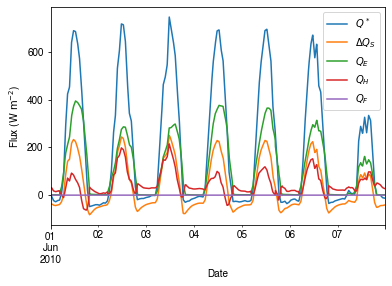

In [69]:
ax_output = df_output_suews\
    .loc['2010-06-01':'2010-06-07',
         ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot()
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
_ = ax_output.legend()

#### Plotting after resampling

The suggested runtime/simulation frequency of SUEWS is `300 s`, which usually results a large output and may be over-weighted for storage and analysis. 
Also, you may feel apparent slowdown in producing the above figure as a large amount of data were used for the plotting.
To slim down the result size for analysis and output, we can `resample` the default output very easily.

In [70]:
rsmp_1d = df_output_suews.resample('1d')
# daily mean values
df_1d_mean = rsmp_1d.mean()
# daily sum values
df_1d_sum = rsmp_1d.sum()

We can then re-examine the above energy balance at hourly scale and plotting will be significantly faster.

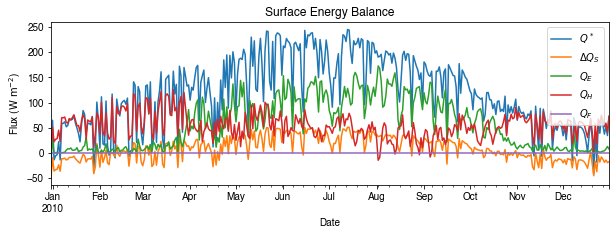

In [71]:
# energy balance
ax_output = df_1d_mean\
    .loc[:, ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot(
            figsize=(10, 3),
            title='Surface Energy Balance',
        )
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
_ = ax_output.legend()

Then we use the hourly results for other analyses.

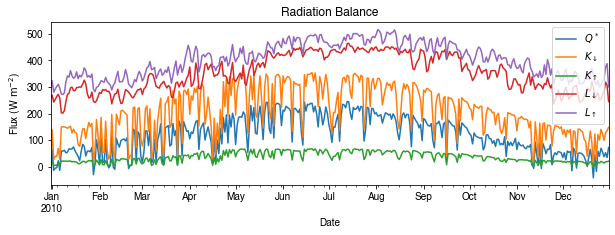

In [72]:
# radiation balance
ax_output = df_1d_mean\
    .loc[:, ['QN', 'Kdown', 'Kup', 'Ldown', 'Lup']]\
    .rename(columns=dict_var_disp)\
    .plot(
        figsize=(10, 3),
        title='Radiation Balance',
    )
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
_ = ax_output.legend()

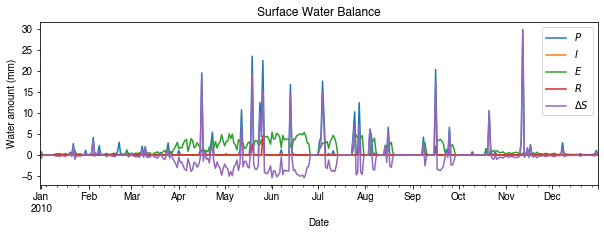

In [73]:
# water balance
ax_output = df_1d_sum\
    .loc[:, ['Rain', 'Irr', 'Evap', 'RO', 'TotCh']]\
    .rename(columns=dict_var_disp)\
    .plot(
        figsize=(10, 3),
        title='Surface Water Balance',
    )
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Water amount (mm)')
_ = ax_output.legend()

Get an overview of partitioning in energy and water balance at monthly scales:

In [74]:
# get a monthly Resampler
df_plot = df_output_suews.copy()
df_plot.index = df_plot.index.set_names('Month')
rsmp_1M = df_plot\
    .shift(-1)\
    .dropna(how='all')\
    .resample('1M', kind='period')
# mean values
df_1M_mean = rsmp_1M.mean()
# sum values
df_1M_sum = rsmp_1M.sum()

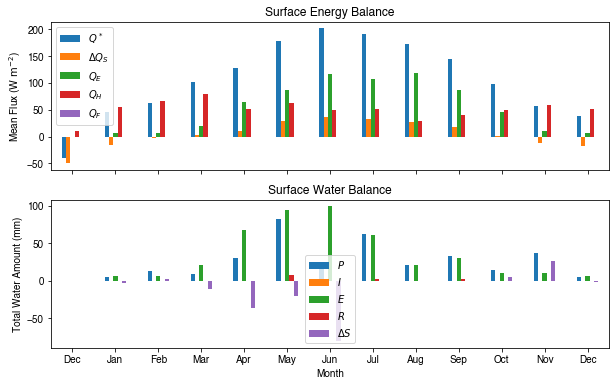

In [75]:
# month names
name_mon = [x.strftime('%b') for x in rsmp_1M.groups]
# create subplots showing two panels together
fig, axes = plt.subplots(2, 1, sharex=True)
# surface energy balance
_=df_1M_mean\
    .loc[:, ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot(
        ax=axes[0],  # specify the axis for plotting
        figsize=(10, 6),  # specify figure size
        title='Surface Energy Balance',
        kind='bar',
    )
# surface water balance
_=df_1M_sum\
    .loc[:, ['Rain', 'Irr', 'Evap', 'RO', 'TotCh']]\
    .rename(columns=dict_var_disp)\
    .plot(
        ax=axes[1],  # specify the axis for plotting
        title='Surface Water Balance',
        kind='bar'
    )

# annotations
_ = axes[0].set_ylabel('Mean Flux ($ \mathrm{W \ m^{-2}}$)')
_ = axes[0].legend()
_ = axes[1].set_xlabel('Month')
_ = axes[1].set_ylabel('Total Water Amount (mm)')
_ = axes[1].xaxis.set_ticklabels(name_mon, rotation=0)
_ = axes[1].legend()

### Save results to external files

The supy output can be saved as `txt` files for further analysis using supy function `save_supy`.

In [76]:
list_path_save = sp.save_supy(df_output, df_state_final)

In [77]:
for file_out in list_path_save:
    print(file_out.name)

98_2009_SUEWS_5.txt
98_2009_snow_5.txt
98_2009_RSL_5.txt
98_2009_DailyState.txt
98_2010_SUEWS_60.txt
98_2010_snow_60.txt
98_2010_RSL_60.txt
df_state.csv


## More explorations into simulation results

In this section, we will use the simulation results to explore more features revealed by SuPy/SUEWS simulations but *unavailable in your simple model*.

### Variability in albedo

#### How does albedo change over time? 

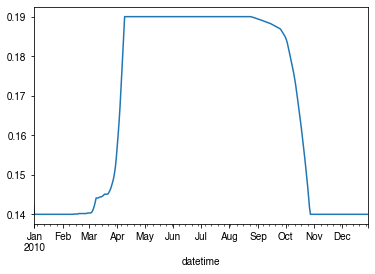

In [78]:
df_dailystate = df_output.loc[grid, 'DailyState'].dropna(
    how='all').resample('1d').mean()
ser_alb = df_dailystate.AlbGrass
_ = ser_alb.plot()

#### How is albedo associated with vegetation phenology?

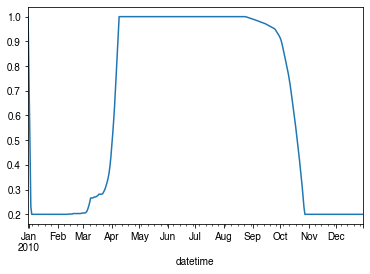

In [79]:
ser_lai = df_dailystate.LAI_Grass
_ = ser_lai.plot()

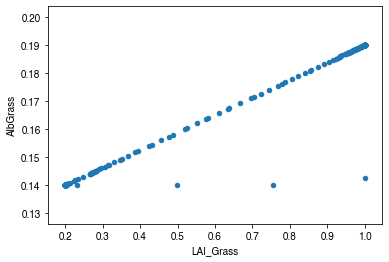

In [80]:
ax_alb_lai = df_dailystate[['LAI_Grass', 'AlbGrass']].plot.scatter(
    x='LAI_Grass',
    y='AlbGrass',
)
ax_alb_lai.set_aspect('auto')

### Variability in surface resistance

#### How does surface resistance vary over time?

In [81]:
ser_rs = df_output_suews.RS

- intra-annual 

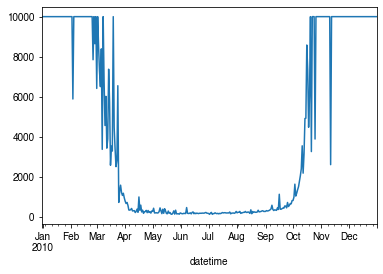

In [82]:
ser_rs.resample('1d').median().plot()

- intra-daily

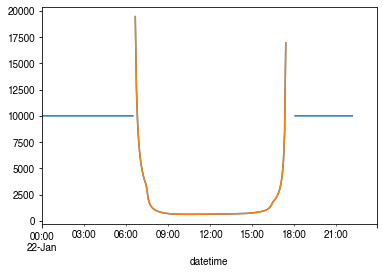

In [83]:
# a winter day
_ = ser_rs.loc['2010-01-22'].plot()
_ = ser_rs.loc['2010-01-22'].between_time('0630', '1800').plot()

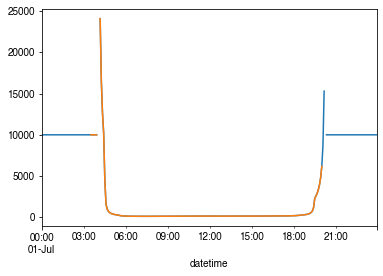

In [88]:
# a summer day
_ = ser_rs.loc['2010-07-01'].plot()
_ = ser_rs.loc['2010-07-01'].between_time('0330', '2000').plot()

#### How is surface resistance associated with other surface properties?

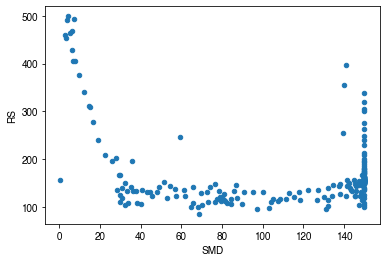

In [102]:
# SMD
ser_smd = df_output_suews.SMD
df_x = pd.concat([ser_smd, ser_rs],
                 axis=1).between_time('1000', '1600').resample('1d').mean()
df_x = df_x.loc[df_x.RS < 500]
_ = df_x.plot.scatter(
    x='SMD',
    y='RS',
)

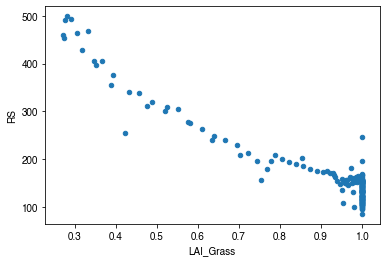

In [110]:
# LAI
df_x = pd.concat(
    [ser_lai,
     ser_rs.between_time('1000', '1600').resample('1d').mean()],
    axis=1)
df_x = df_x.loc[df_x.RS < 500]
_ = df_x.plot.scatter(
    x='LAI_Grass',
    y='RS',
)

#### How is surface resistance dependent on meteorological conditions?

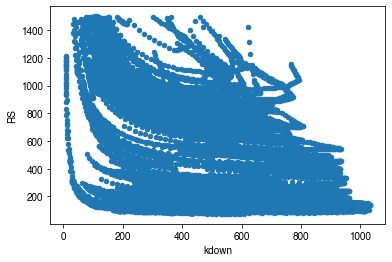

In [119]:
# solar radiation
ser_kdown = df_forcing_amf.kdown
df_x = pd.concat([ser_kdown, ser_rs], axis=1).between_time('1000', '1600')
df_x = df_x.loc[df_x.RS < 1500]
_ = df_x.plot.scatter(
    x='kdown',
    y='RS',
)

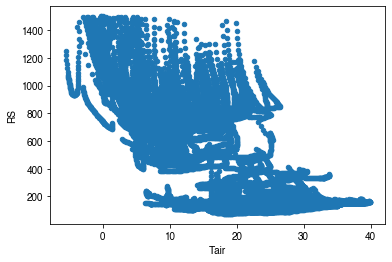

In [120]:
# air temperature
ser_ta = df_forcing_amf.Tair
df_x = pd.concat([ser_ta, ser_rs], axis=1).between_time('1000', '1600')
df_x = df_x.loc[df_x.RS < 1500]
_ = df_x.plot.scatter(
    x='Tair',
    y='RS',
)

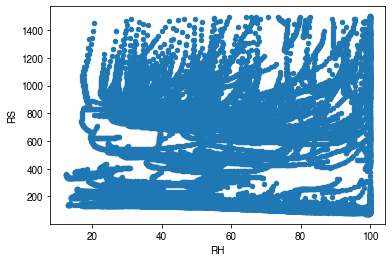

In [121]:
# air humidity
ser_rh = df_forcing_amf.RH
df_x = pd.concat([ser_rh, ser_rs], axis=1).between_time('1000', '1600')
df_x = df_x.loc[df_x.RS < 1500]
_ = df_x.plot.scatter(
    x='RH',
    y='RS',
)

- **Task:**

Based on the above plots showing `RS` vs. met. conditions, explore these relationships again at the intra-daily scales.

### How does soil moisture influence evapotranspiration?

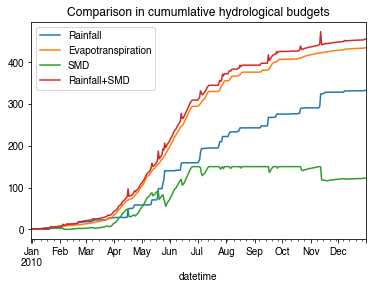

In [151]:
ser_rain_cum = df_forcing_amf.rain.cumsum().resample('1d').max()
_ = ser_rain_cum.plot(label='Rainfall')
_ = df_output_suews.Evap.cumsum().resample('1d').max().plot(
    label='Evapotranspiration')


ser_smd_cum = ser_smd.resample('1d').max()
_ = ser_smd_cum.plot(label='SMD')
ax = (ser_rain_cum + ser_smd_cum).plot(label='Rainfall+SMD')
_ = ax.legend()
_ = ax.set_title('Comparison in cumumlative hydrological budgets')

- **Question:**

Apparently, gap is observed between `SMD` and `Rainfall+SMD`; what does this gap represent?
